In [1]:
import numpy as np
import astropy.io.fits as fits
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from IPython.display import clear_output, display
import time
from pathlib import Path
import copy

import proper
proper.prop_use_fftw(DISABLE=False)

import roman_phasec_proper

import cgi_phasec_poppy as cgi

import ray

import misc_funs as misc

data_dir = Path('/groups/douglase/kians-data-files/disk-processing')

dm1_best = fits.getdata(roman_phasec_proper.lib_dir + r'/examples/spc_wide_band4_best_contrast_dm1.fits')
dm2_best = fits.getdata(roman_phasec_proper.lib_dir + r'/examples/spc_wide_band4_best_contrast_dm2.fits')

In [2]:
wavelength_c = 825e-9*u.m
D = 2.3631*u.m
mas_per_lamD = (wavelength_c/D*u.radian).to(u.mas)

npsf = 64
psf_pixelscale = 13e-6
psf_pixelscale_lamD = 500/825 * 1/2
psf_pixelscale_mas = psf_pixelscale_lamD*mas_per_lamD/u.pix

iwa = 6
owa = 20

# Create the sampling grid the PSFs will be made on
sampling1 = 0.1
sampling2 = 0.2
sampling3 = 0.5
offsets1 = np.arange(0,iwa+1,sampling1)
offsets2 = np.arange(iwa+1,owa,sampling2)
offsets3 = np.arange(owa,owa+5+sampling3,sampling3)

r_offsets = np.hstack([offsets1, offsets2, offsets3])
nr = len(r_offsets)
r_offsets_mas = r_offsets*mas_per_lamD
display(nr, r_offsets)

sampling_theta = 15
thetas = np.arange(0,360,sampling_theta)*u.deg
nth = len(thetas)
display(nth, thetas)

psfs_required = (nr-1)*nth + 1
display(psfs_required)

# r_offsets_hdu = fits.PrimaryHDU(data=r_offsets)
# r_offsets_fpath = data_dir/'psfs'/'hlc_band1_psfs_radial_samples_20230501.fits'
# r_offsets_hdu.writeto(r_offsets_fpath, overwrite=True)

# thetas_hdu = fits.PrimaryHDU(data=thetas.value)
# thetas_fpath = data_dir/'psfs'/'hlc_band1_psfs_theta_samples_20230501.fits'
# thetas_hdu.writeto(thetas_fpath, overwrite=True)


146

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,
        8.4,  8.6,  8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. , 10.2, 10.4,
       10.6, 10.8, 11. , 11.2, 11.4, 11.6, 11.8, 12. , 12.2, 12.4, 12.6,
       12.8, 13. , 13.2, 13.4, 13.6, 13.8, 14. , 14.2, 14.4, 14.6, 14.8,
       15. , 15.2, 15.4, 15.6, 15.8, 16. , 16.2, 16.4, 16.6, 16.8, 17. ,
       17.2, 17.4, 17.6, 17.8, 18. , 18.2, 18.4, 18.6, 18.8, 19. , 19.2,
       19.4, 19.6, 19.8, 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5,
       24. , 24.5, 25. ])

24

<Quantity [  0.,  15.,  30.,  45.,  60.,  75.,  90., 105., 120., 135.,
           150., 165., 180., 195., 210., 225., 240., 255., 270., 285.,
           300., 315., 330., 345.] deg>

3481

Text(0.5, 1.0, 'Distribution of PRFs')

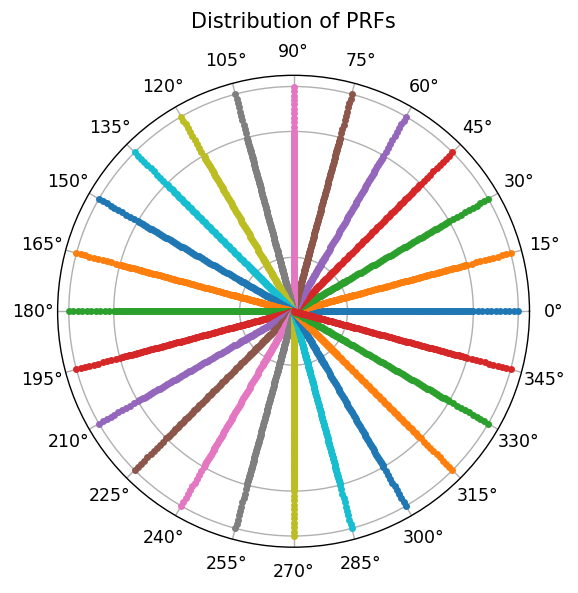

In [3]:
# Plotting field angles
theta_offsets = []
for r in r_offsets[1:]:
    theta_offsets.append(thetas.to(u.radian).value)
theta_offsets = np.array(theta_offsets)
theta_offsets.shape

fig = plt.figure(dpi=125, figsize=(5,5))

ax1 = plt.subplot(111, projection='polar')
ax1.plot(theta_offsets, r_offsets[1:], '.')
ax1.set_rticks([iwa, owa, max(r_offsets)], linewidth=4)  # Less radial ticks
# ax1.set_rticks([])  # Less radial ticks
ax1.set_yticklabels([])
ax1.set_thetagrids(thetas.value)
ax1.set_rlabel_position(55)  # Move radial labels away from plotted line
ax1.grid(True)
ax1.set_title('Distribution of PRFs', va='bottom')

In [4]:
rayCGI = ray.remote(cgi.PROPERCGI)

nlam = 5
bandwidth = 0.10
minlam = wavelength_c * (1 - bandwidth/2)
maxlam = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minlam, maxlam, nlam )

npol = 4
polaxis = np.array([-2, -1, 1, 2])

mode_settings = {
    'cgi_mode':'spc-wide',
    'use_pupil_defocus':True,    
    'use_opds':True,
    'npsf':150,
}

actors = []
for i in range(nlam):
    for j in range(npol):
        actors.append(rayCGI.options(num_cpus=3).remote(wavelength=wavelengths[i],
                                                        polaxis=polaxis[j], 
                                                        **mode_settings))

In [5]:
spcw = cgi.multiCGI(actors)

spcw.set_dm1(dm1_best)
spcw.set_dm2(dm2_best)

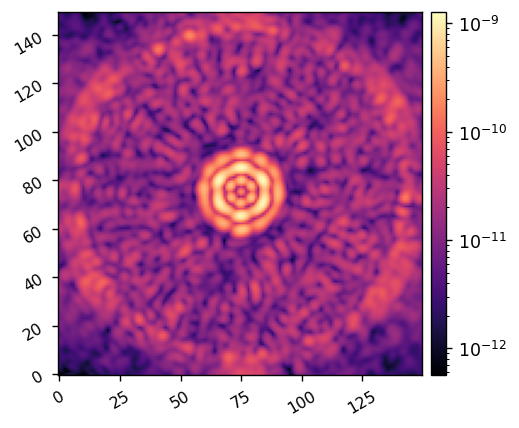

In [6]:
im = spcw.snap()
misc.imshow1(im, lognorm=True)

(9241, 64, 64)


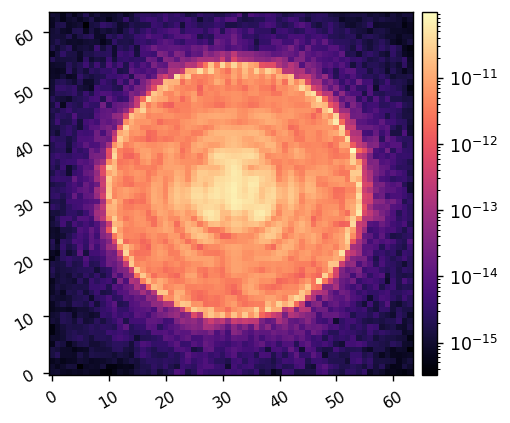

0
(r,theta) = (0.0, 0.0)
(x,y) = (0.0, 0.0)
computation time =  14.71239686012268


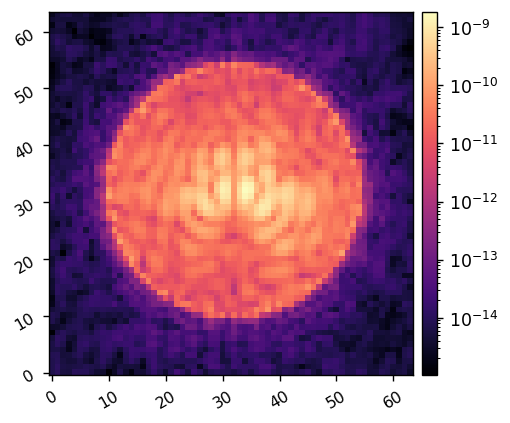

1
(r,theta) = (0.05, 0.0)
(x,y) = (0.05, 0.0)
computation time =  30.017799377441406


KeyboardInterrupt: 

In [9]:
start = time.time()

psfs_array = np.zeros( shape=( (nr-1)*nth + 1, npsf,npsf) )
print(psfs_array.shape)

count = 0
for i,r in enumerate(r_offsets): 
    for j,th in enumerate(thetas):
        xoff = r*np.cos(th)
        yoff = r*np.sin(th)

        hlc.source_offset((xoff.value,yoff.value))
        psf = hlc.snap()
        misc.imshow1(psf, lognorm=True)
        print(count) 
        print('(r,theta) =', (r, th.value))
        print('(x,y) =', (xoff.value, yoff.value))
        print('computation time = ', time.time()-start)
        
        if r<r_offsets[1]: 
            psfs_array[0] = psf
            count += 1
            break
        else: 
            psfs_array[count] = psf
            
        count += 1

In [11]:
9241*15/3600

38.50416666666667

In [14]:
hdr = fits.Header()
hdr['PXSCLAMD'] = psf_pixelscale_lamD
hdr.comments['PXSCLAMD'] = 'pixel scale in lam0/D per pixel'
hdr['PXSCLMAS'] = psf_pixelscale_mas.value
hdr.comments['PXSCLMAS'] = 'pixel scale in mas per pixel'
hdr['PIXELSCL'] = psf_pixelscale
hdr.comments['PIXELSCL'] = 'pixel scale in meters per pixel'
hdr['CWAVELEN'] = wavelength_c.to_value(u.m)
hdr.comments['CWAVELEN'] = 'central wavelength in meters'
hdr['BANDPASS'] = bandwidth
hdr.comments['BANDPASS'] = 'bandpass as fraction of CWAVELEN'

psfs_hdu = fits.PrimaryHDU(data=psfs_array, header=hdr)

psfs_fpath = data_dir/'psfs'/'spcw_band4_psfs_20230504.fits'
psfs_hdu.writeto(psfs_fpath, overwrite=True)
